In [69]:
# import libraries
import pandas as pd
import geopandas as gpd 

import folium
from folium import plugins # sirve para hacer mapas interactivos

# import matplotlib
import matplotlib.pyplot as plt # superior en cuestion de rendimiento
import contextily as ctx # sirve para poner mapas de fondo

import seaborn as sns # para hacer graficos mas bonitos

import json 
import pydeck as pdk # for 3D maps, buen resultado, muy visual

from shapely.geometry import LineString, Point 

import numpy as np

In [71]:
# Variables globales
latitud = 41.155
longitud = -8.63
zoom = 13
nrows = 100000
# Ruta del archivo CSV
filename = "../train_data/taxis_trajectory/train.csv"

In [73]:
def load_and_simplify_data(filename, rows, tolerance=0.001):
    # Cargar datos
    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)
    
    # Filtrar polilíneas vacías o con un solo punto
    def create_line(x):
        points = json.loads(x)
        if len(points) > 1:
            return LineString(points)
        return None

    df['geometry'] = df['POLYLINE'].apply(create_line)
    
    # Eliminar filas con geometrías nulas
    df = df[df['geometry'].notnull()]
    
    # Convertir a Geopandas DataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Simplificar las geometrías
    gdf['geometry'] = gdf['geometry'].simplify(tolerance)
    
    return gdf


In [ ]:
# Cargar y simplificar datos
gdf = load_and_simplify_data(filename, nrows)
gdf.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,geometry
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","LINESTRING (-8.61864 41.14141, -8.63275 41.146..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","LINESTRING (-8.63985 41.15983, -8.67085 41.165..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...","LINESTRING (-8.61296 41.14036, -8.61421 41.140..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","LINESTRING (-8.57468 41.15195, -8.58074 41.145..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","LINESTRING (-8.64599 41.18049, -8.64680 41.178..."


Pruevas de mapa segmentado con y sin columna adicional, muy lento

In [ ]:
"""  def plot_polylines_on_map(gdf, start_location, map_zoom_start=12):
    # Crear un mapa base
    m = folium.Map(location=start_location, zoom_start=map_zoom_start)

    # Añadir las polilíneas al mapa
    for _, row in gdf.iterrows():
        polyline = row['geometry'].coords[:]
        folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)

    return m """

"  def plot_polylines_on_map(gdf, start_location, map_zoom_start=12):\n    # Crear un mapa base\n    m = folium.Map(location=start_location, zoom_start=map_zoom_start)\n\n    # Añadir las polilíneas al mapa\n    for _, row in gdf.iterrows():\n        polyline = row['geometry'].coords[:]\n        folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)\n\n    return m "

In [ ]:
# Prueva mapa segmetado con columna adicional, muy lento

""" # Definir una ubicación inicial para centrar el mapa (modifica con tus coordenadas)
start_location = [41.155, -8.63]

# Crear y mostrar el mapa
m = plot_polylines_on_map(gdf, start_location)
m """

' # Definir una ubicación inicial para centrar el mapa (modifica con tus coordenadas)\nstart_location = [41.155, -8.63]\n\n# Crear y mostrar el mapa\nm = plot_polylines_on_map(gdf, start_location)\nm '

In [ ]:
# Prueva mapa segmetado sin columna adicional, muy lento

""" # Crear un mapa base
m = folium.Map(location=[latitud, longitud], zoom_start=zoom)

# Añadir las polilíneas
for _, row in gdf.iterrows():
    polyline = json.loads(row['POLYLINE'])
    folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)

# mostrar el mapa
m """

" # Crear un mapa base\nm = folium.Map(location=[latitud, longitud], zoom_start=zoom)\n\n# Añadir las polilíneas\nfor _, row in gdf.iterrows():\n    polyline = json.loads(row['POLYLINE'])\n    folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)\n\n# mostrar el mapa\nm "

Prueva de pydeck, la mas visual de todas pero es muy lento y pesado

In [ ]:
# Prueva de pydeck, la mas visual de todas pero es muy lento y pesado

""" # Verificar el formato actual de 'POLYLINE'
gdf['POLYLINE'] = gdf['POLYLINE'].apply(json.loads)
print(gdf['POLYLINE'].head()) """

" # Verificar el formato actual de 'POLYLINE'\ngdf['POLYLINE'] = gdf['POLYLINE'].apply(json.loads)\nprint(gdf['POLYLINE'].head()) "

In [ ]:
# Intento de suabizar las polilineas, no funciona

""" def chaikin_smoothing(points, iterations=2):
    # Aplica el algoritmo de suavizado de Chaikin a una serie de puntos.
    if len(points) < 3:
        return points  # No se puede suavizar si hay menos de 3 puntos

    for _ in range(iterations):
        new_points = [points[0]]  # El primer punto siempre se mantiene
        for i in range(len(points) - 1):
            p0 = points[i]
            p1 = points[i + 1]
            q = [0.75 * p0[0] + 0.25 * p1[0], 0.75 * p0[1] + 0.25 * p1[1]]
            r = [0.25 * p0[0] + 0.75 * p1[0], 0.25 * p0[1] + 0.75 * p1[1]]
            new_points.extend([q, r])
        new_points.append(points[-1])  # El último punto siempre se mantieneooooooooooooo
        points = new_points

    return points

# Aplicar el suavizado a cada polilínea
gdf['SMOOTHED_POLYLINE'] = gdf['POLYLINE'].apply(chaikin_smoothing) """

" def chaikin_smoothing(points, iterations=2):\n    # Aplica el algoritmo de suavizado de Chaikin a una serie de puntos.\n    if len(points) < 3:\n        return points  # No se puede suavizar si hay menos de 3 puntos\n\n    for _ in range(iterations):\n        new_points = [points[0]]  # El primer punto siempre se mantiene\n        for i in range(len(points) - 1):\n            p0 = points[i]\n            p1 = points[i + 1]\n            q = [0.75 * p0[0] + 0.25 * p1[0], 0.75 * p0[1] + 0.25 * p1[1]]\n            r = [0.25 * p0[0] + 0.75 * p1[0], 0.25 * p0[1] + 0.75 * p1[1]]\n            new_points.extend([q, r])\n        new_points.append(points[-1])  # El último punto siempre se mantieneooooooooooooo\n        points = new_points\n\n    return points\n\n# Aplicar el suavizado a cada polilínea\ngdf['SMOOTHED_POLYLINE'] = gdf['POLYLINE'].apply(chaikin_smoothing) "

In [ ]:
""" # Transformar cada línea en un diccionario
lines_data = [{"path": polyline, "color": [255, 0, 0]} for polyline in gdf['POLYLINE']]
lines_df = pd.DataFrame(lines_data)

# Configurar la vista inicial
view_state = pdk.ViewState(latitude=latitud, longitude=longitud, zoom=zoom)

# Crear la capa de líneas
layer = pdk.Layer(
    type="PathLayer",
    data=lines_df,
    get_path="path",
    get_color="color",
    width_min_pixels=2.5,
    pickable=True
)

# Renderizar el mapa
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show() """

' # Transformar cada línea en un diccionario\nlines_data = [{"path": polyline, "color": [255, 0, 0]} for polyline in gdf[\'POLYLINE\']]\nlines_df = pd.DataFrame(lines_data)\n\n# Configurar la vista inicial\nview_state = pdk.ViewState(latitude=latitud, longitude=longitud, zoom=zoom)\n\n# Crear la capa de líneas\nlayer = pdk.Layer(\n    type="PathLayer",\n    data=lines_df,\n    get_path="path",\n    get_color="color",\n    width_min_pixels=2.5,\n    pickable=True\n)\n\n# Renderizar el mapa\nr = pdk.Deck(layers=[layer], initial_view_state=view_state)\nr.show() '

Prueva geopamdas ,matplotlib y seaborn, la mas rapida pero no mustra mapa

In [ ]:
# Prueva geopamdas ,matplotlib y seaborn, la mas rapida pero no mustra mapa

""" # Configurar el tamaño de la figura con Matplotlib
plt.rcParams['figure.figsize'] = [15, 8]

# Configurar el estilo de los gráficos con Seaborn
sns.set(style="darkgrid")

# Dibujar el gráfico
# Si tu GeoDataFrame tiene una columna 'geometry', la usamos directamente
gdf.plot(figsize=[15, 15])

# Configurar las etiquetas de los ejes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar el gráfico
# plt.show()

plt.savefig("mapa_visualizacion.png") """


' # Configurar el tamaño de la figura con Matplotlib\nplt.rcParams[\'figure.figsize\'] = [15, 8]\n\n# Configurar el estilo de los gráficos con Seaborn\nsns.set(style="darkgrid")\n\n# Dibujar el gráfico\n# Si tu GeoDataFrame tiene una columna \'geometry\', la usamos directamente\ngdf.plot(figsize=[15, 15])\n\n# Configurar las etiquetas de los ejes\nplt.xlabel(\'Longitude\')\nplt.ylabel(\'Latitude\')\n\n# Mostrar el gráfico\n# plt.show()\n\nplt.savefig("mapa_visualizacion.png") '

Prueva con folium y geopandas poner las polilineas encima, demasado lento

In [ ]:
# Prueva con folium y geopandas poner las polilineas encima, demasado lento

"""
# Crear un mapa base en folium
m = folium.Map(location=[latitud, longitud], zoom_start=zoom)

# Dibujar las polilíneas en el mapa de Folium
for _, row in gdf.iterrows():
    # Asegúrate de que la geometría no es nula
    if row['geometry'] is not None:
        # Simplificar la geometría para mejorar la eficiencia
        simplified_line = row['geometry'].simplify(0.001)
        # Extraer las coordenadas de la línea
        line_coords = [[point[1], point[0]] for point in list(simplified_line.coords)]
        # Dibujar la línea en el mapa
        folium.PolyLine(line_coords, color='blue', weight=2.5, opacity=1).add_to(m)

# Mostrar el mapa
m.save('map.html')  # Guardar el mapa en un archivo HTML para visualizar en un navegador """


"\n# Crear un mapa base en folium\nm = folium.Map(location=[latitud, longitud], zoom_start=zoom)\n\n# Dibujar las polilíneas en el mapa de Folium\nfor _, row in gdf.iterrows():\n    # Asegúrate de que la geometría no es nula\n    if row['geometry'] is not None:\n        # Simplificar la geometría para mejorar la eficiencia\n        simplified_line = row['geometry'].simplify(0.001)\n        # Extraer las coordenadas de la línea\n        line_coords = [[point[1], point[0]] for point in list(simplified_line.coords)]\n        # Dibujar la línea en el mapa\n        folium.PolyLine(line_coords, color='blue', weight=2.5, opacity=1).add_to(m)\n\n# Mostrar el mapa\nm.save('map.html')  # Guardar el mapa en un archivo HTML para visualizar en un navegador "

Prueva con matplotlib y contextily, por ahora la mas rapida (2:14 archivo completo) (0:10 solo 100000 filas), no es la mas visula, el resultado es una imagen

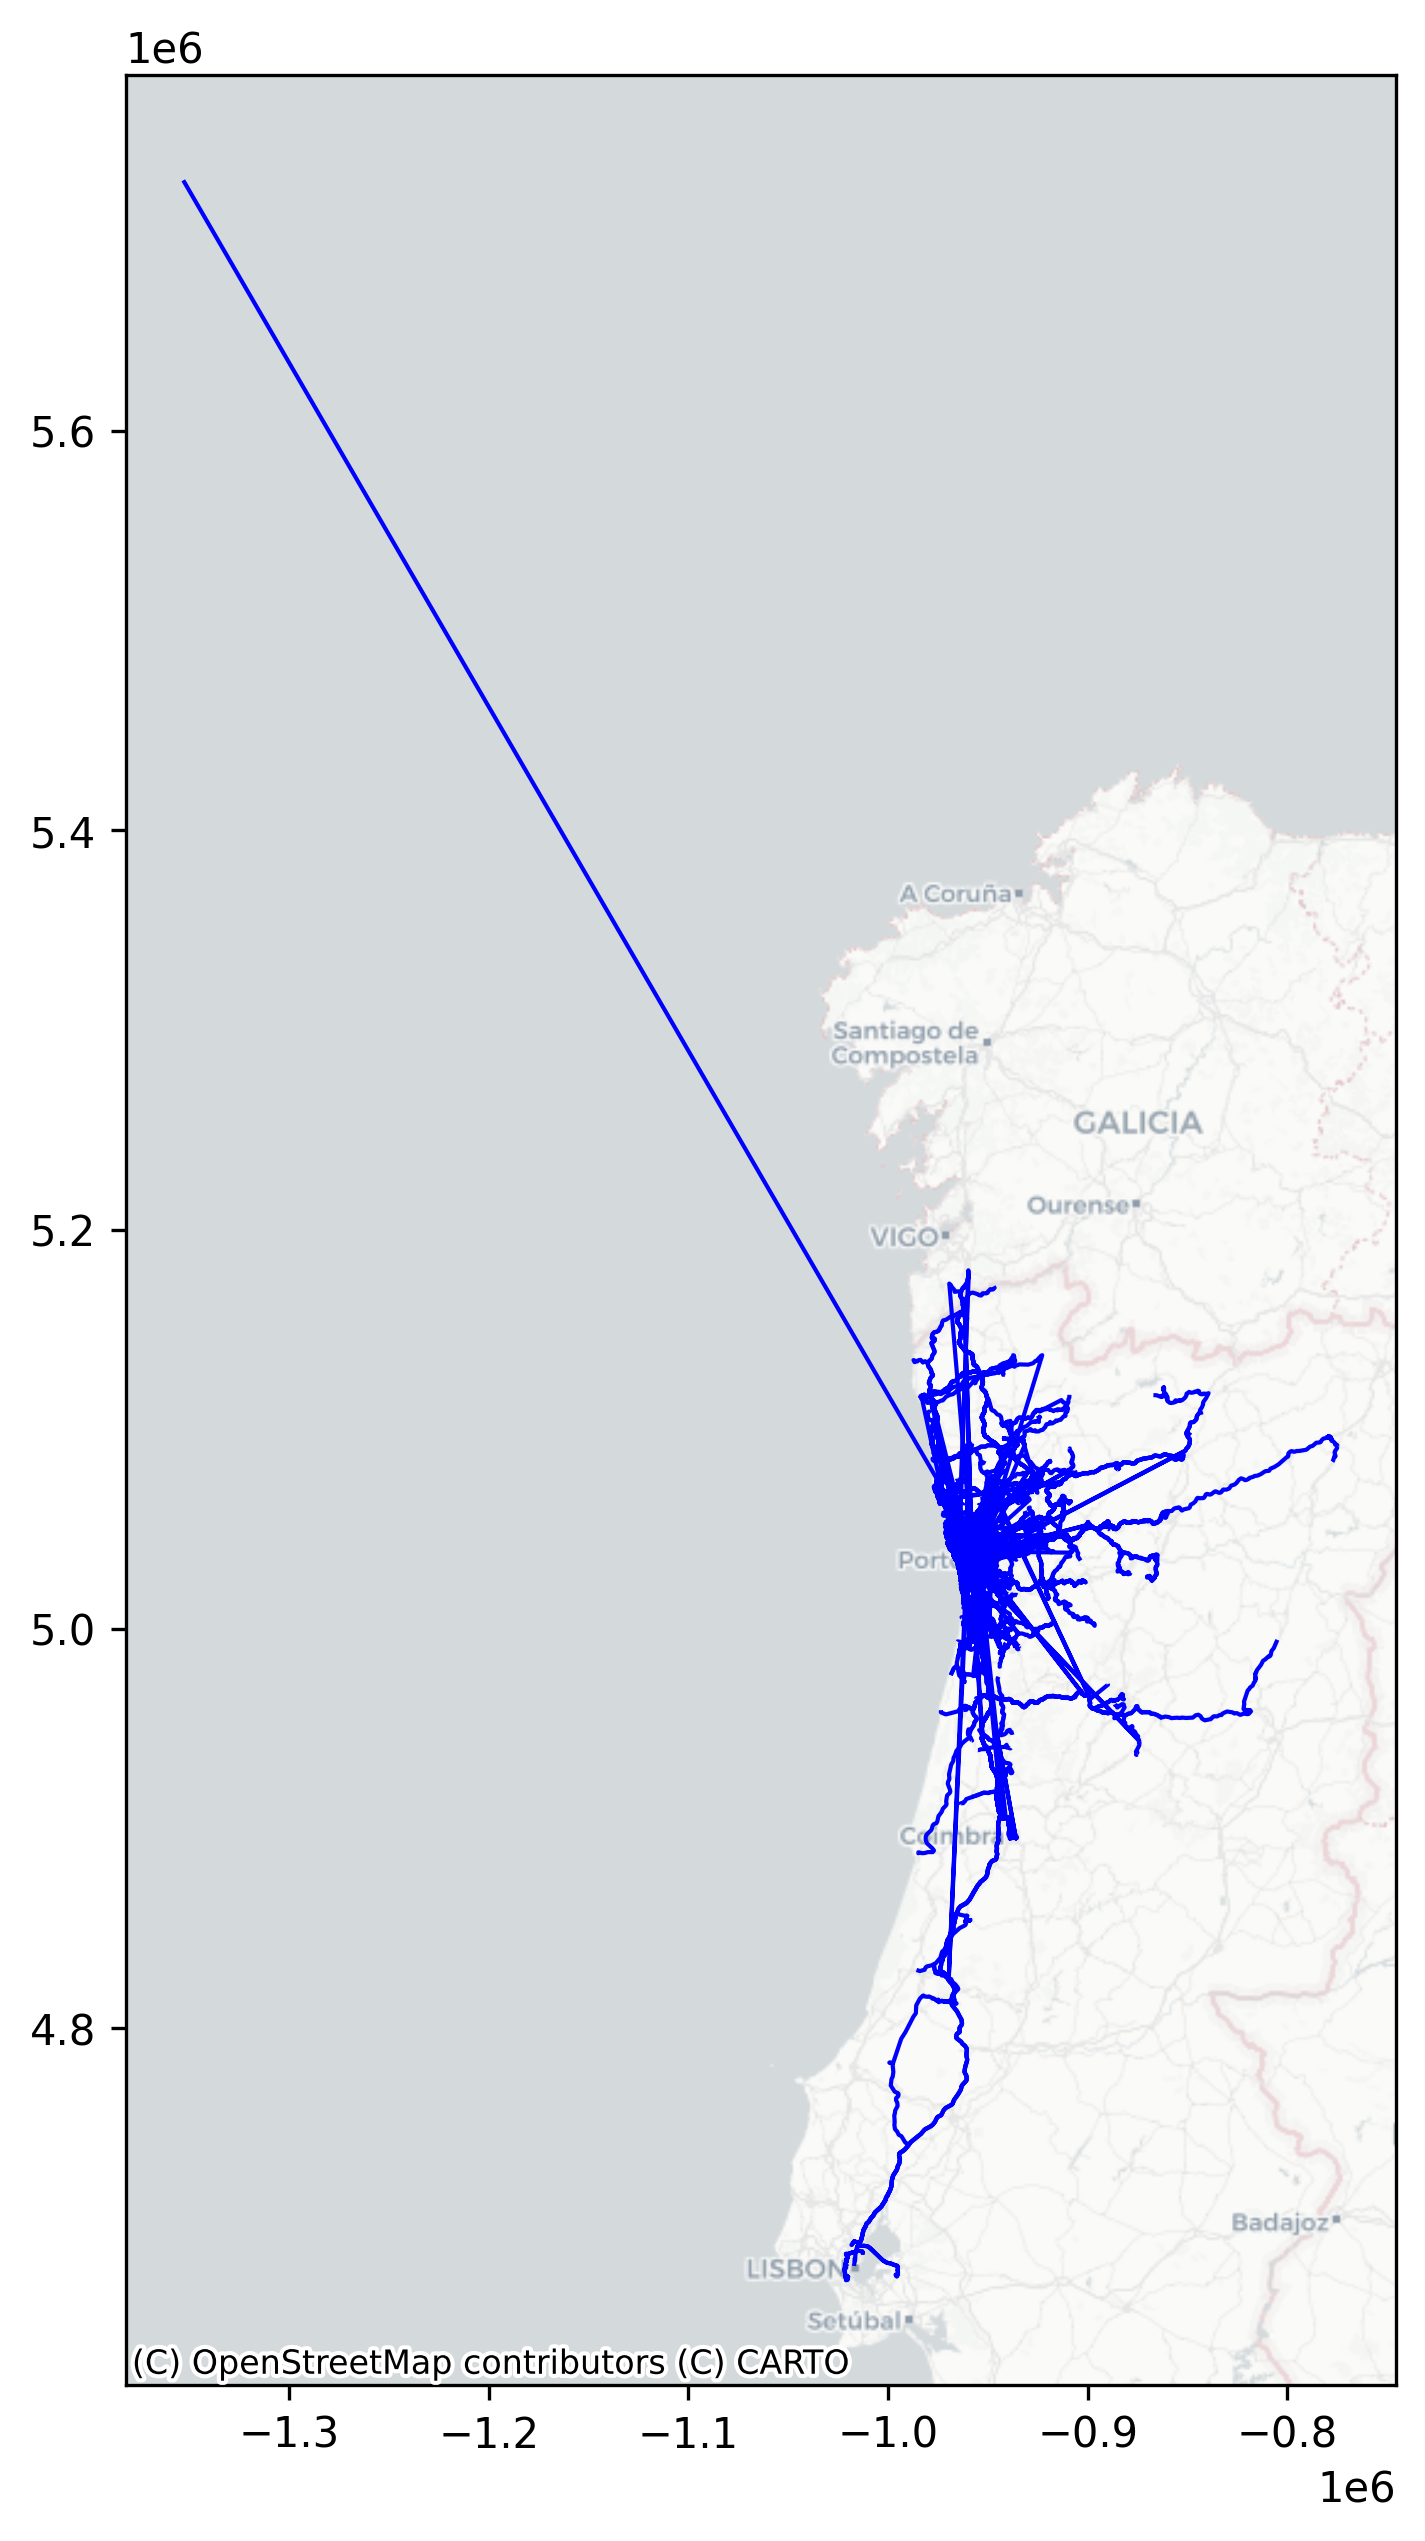

In [ ]:
# Prueva con matplotlib y contextily, por ahora la mas rapida (2:14 archivo completo) (0:10 solo 100000 filas), no es la mas visula, el resultado es una imagen

""" # Establecer el CRS a EPSG:4326 si los datos están en coordenadas longitud/latitud
gdf = gdf.set_crs("EPSG:4326")

# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily
gdf = gdf.to_crs(epsg=3857)

# Crear una figura con Matplotlib
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
gdf.plot(ax=ax, linewidth=1, color='blue')

# Añadir un mapa base con Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Guardar la imagen con fondo transparente
plt.savefig('map_overlay.png', bbox_inches='tight', pad_inches=0, transparent=True)

# Crear un mapa base en Folium
m = folium.Map([latitud, longitud], zoom_start=zoom, tiles='cartodbpositron')

# Añadir la imagen como overlay en Folium
img = folium.raster_layers.ImageOverlay(
    name='Matplotlib Overlay',
    image='map_overlay.png',
    bounds=[[gdf.bounds.miny.min(), gdf.bounds.minx.min()], [gdf.bounds.maxy.max(), gdf.bounds.maxx.max()]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

img.add_to(m)
folium.LayerControl().add_to(m) """